Facultad de Ingeniería UACH

Maestría en Ingeniería en Computación

Materia: Machine Learning

Alumno: Iván Avena Caro

Matricula: 193650

# **Estudiantes**

Usar atributos, caracteristicas de los estudiantes, para predecir el exito, el fracaso o que el estudiante siga matriculado, es un problema  de clasificación de clases multiples. El target es Graduate, Enrolled o Dropout

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [44]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, recall_score, precision_score,
                             f1_score, confusion_matrix, classification_report)
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from IPython.display import display, HTML
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

import joblib
import pickle

In [3]:
sns.set()

In [4]:
data = pd.read_csv('/content/dataset - copia (4) - copia - copia - copia.csv')

In [5]:
#obtener vista de todas las claves
data.keys()

Index(['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance', 'Previous qualification', 'Nacionality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Displaced',
       'Educational special needs', 'Debtor', 'Tuition fees up to date',
       'Gender', 'Scholarship holder', 'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)',
       'Curricular units 2nd sem (without evaluations)

In [6]:
print(data.head)

<bound method NDFrame.head of       Marital status  Application mode  Application order  Course  \
0                  1                 8                  5       2   
1                  1                 6                  1      11   
2                  1                 1                  5       5   
3                  1                 8                  2      15   
4                  2                12                  1       3   
...              ...               ...                ...     ...   
4419               1                 1                  6      15   
4420               1                 1                  2      15   
4421               1                 1                  1      12   
4422               1                 1                  1       9   
4423               1                 5                  1      15   

      Daytime/evening attendance  Previous qualification  Nacionality  \
0                              1                       1            

In [7]:
#Columna target
data["Target"]

,Target
0,Dropout
1,Graduate
2,Dropout
3,Graduate
4,Graduate
...,...
4419,Graduate
4420,Dropout
4421,Dropout
4422,Graduate


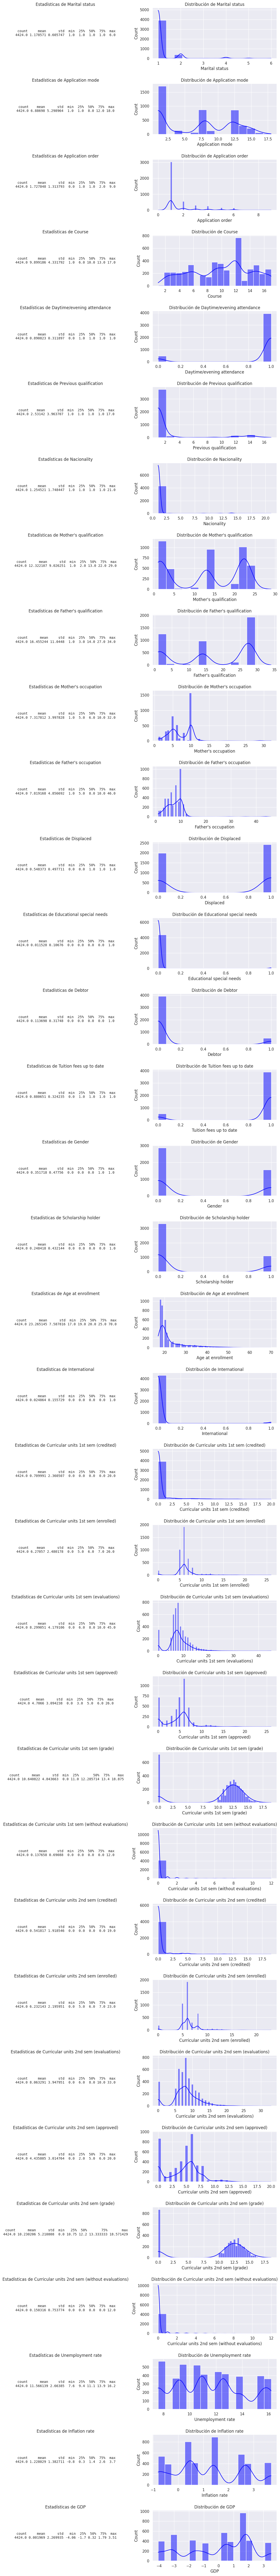

In [8]:
# Seleccionar solo las columnas numéricas
data_numerica = data.select_dtypes(include=['number'])

# Calcular estadísticas descriptivas
estadisticas = data_numerica.describe()

# Crear una figura para la tabla de estadísticas y gráficos
fig, axarr = plt.subplots(nrows=len(data_numerica.columns), ncols=2, figsize=(14, len(data_numerica.columns) * 4))
fig.subplots_adjust(left=0.1, right=0.9, hspace=0.5)  # Ajustar el espacio entre las subgráficas

for i, columna in enumerate(data_numerica.columns):
    # Graficar la distribución
    sns.histplot(data_numerica[columna], ax=axarr[i, 1], kde=True, color='blue')
    axarr[i, 1].set_title(f'Distribución de {columna}')

    # Mostrar estadísticas descriptivas en la primera columna
    estadisticas_texto = estadisticas[[columna]].T.to_string(index=False)
    axarr[i, 0].text(0.5, 0.5, estadisticas_texto, fontsize=10, ha='center', va='center', family='monospace')
    axarr[i, 0].set_title(f'Estadísticas de {columna}')
    axarr[i, 0].axis('off')  # Desactivar los ejes para que solo se vea el texto

plt.show()

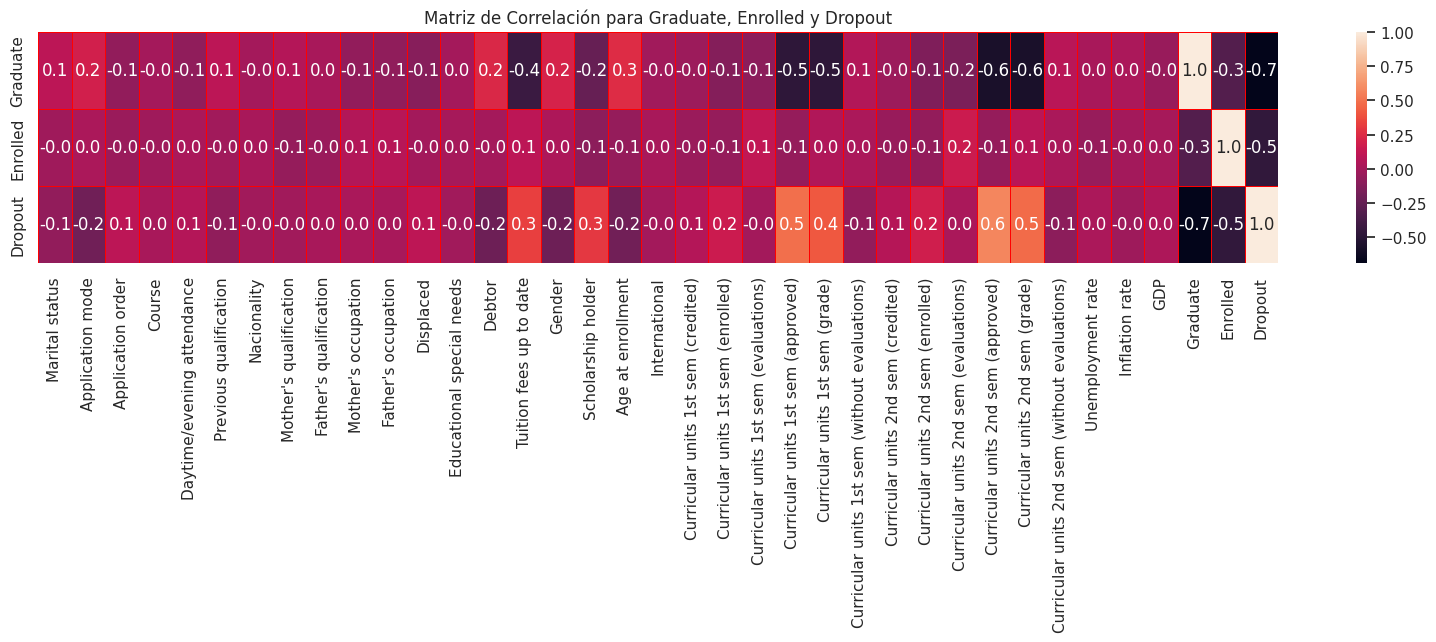

In [9]:
# Codificar la columna de Target
target = data["Target"]
enc = LabelEncoder()
target_label = enc.fit_transform(target)  # Transforma 'Graduate', 'Enrolled' y 'Dropout' en 0 y 1

# One-Hot Encoding
target_cate = to_categorical(target_label)  # Convierte a formato one-hot
target_cate = pd.DataFrame(target_cate, columns=['Graduate', 'Enrolled','Dropout'])  # Nombrar las columnas

# Eliminar la columna original y añadir las nuevas columnas
data.drop(columns=['Target'], inplace=True)
data["Graduate"] = target_cate["Graduate"]
data["Enrolled"] = target_cate["Enrolled"]
data["Dropout"] = target_cate["Dropout"]

# Calcular la matriz de correlación
b = data.corr()
b = b.loc[["Graduate", "Enrolled","Dropout" ], :]  # Extraer la matriz de correlación

# Visualizar la matriz de correlación
f, ax = plt.subplots(figsize=(20, 3))  # Ajusta el tamaño de la figura
sns.heatmap(b, annot=True, linewidths=0.5, linecolor="red", fmt='.1f', ax=ax)
plt.title('Matriz de Correlación para Graduate, Enrolled y Dropout')
plt.show()

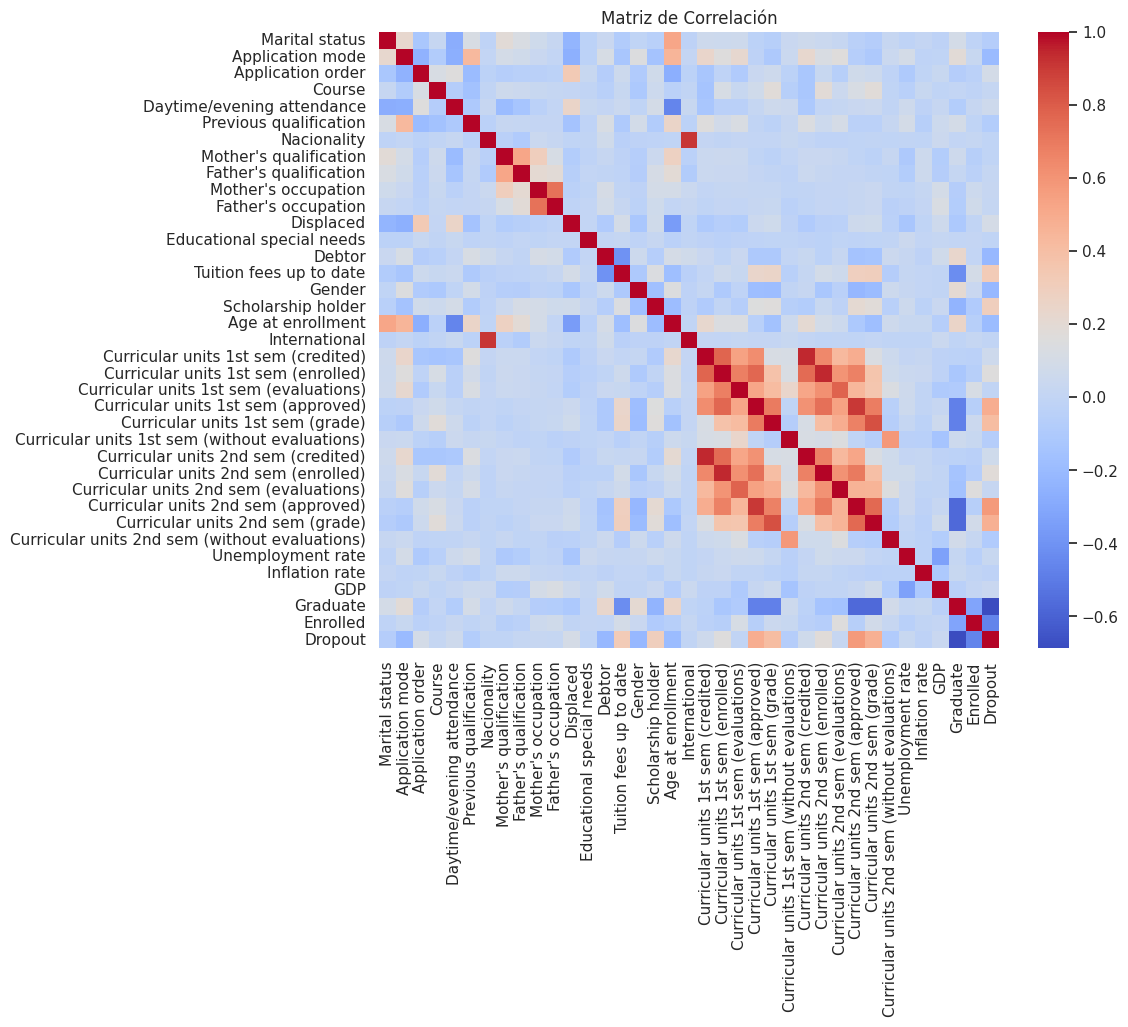

In [10]:
# Seleccionar solo columnas numéricas
numerical_data = data.select_dtypes(include=[np.number])

# Calcular la matriz de correlación
correlation_matrix = numerical_data.corr(method='pearson')

# Crear un DataFrame para almacenar pares de correlación
correlation_pairs = correlation_matrix.unstack().reset_index()
correlation_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']

# Filtrar los pares con una correlación significativa
significant_pairs = correlation_pairs[(correlation_pairs['Correlation'] > 0.7) | (correlation_pairs['Correlation'] < -0.7)]

# Eliminar duplicados (por ejemplo, (A, B) y (B, A))
significant_pairs = significant_pairs[significant_pairs['Variable 1'] != significant_pairs['Variable 2']]
significant_pairs = significant_pairs.drop_duplicates(subset=['Correlation'], keep='first')

# Ordenar por valor de correlación
significant_pairs = significant_pairs.sort_values(by='Correlation', ascending=False)

# Crear el mapa de calor sin números
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

In [11]:
# Seleccionar solo columnas numéricas
numerical_data = data.select_dtypes(include=[np.number])

# Calcular la matriz de correlación
correlation_matrix = numerical_data.corr(method='pearson')

# Crear un DataFrame para almacenar pares de correlación
correlation_pairs = correlation_matrix.unstack().reset_index()
correlation_pairs.columns = ['Feature', 'Colinear With', 'Pearson']

# Filtrar los pares con una correlación significativa (mayor a 0.7 o menor a -0.7)
significant_pairs = correlation_pairs[(correlation_pairs['Pearson'] > 0.7) | (correlation_pairs['Pearson'] < -0.7)]

# Eliminar duplicados (por ejemplo, (A, B) y (B, A))
significant_pairs = significant_pairs[significant_pairs['Feature'] != significant_pairs['Colinear With']]
significant_pairs = significant_pairs.drop_duplicates(subset=['Pearson'], keep='first')

# Ordenar por valor de correlación
significant_pairs = significant_pairs.sort_values(by='Pearson', ascending=False)

# Formatear y mostrar la tabla con encabezados en negrita
html_table = significant_pairs.to_html(index=False, escape=False)
html_table = html_table.replace('<table', '<table style="width: 100%;"')
html_table = html_table.replace('<th>', '<th style="font-weight: bold;">')
display(HTML(html_table))

Feature,Colinear With,Pearson
Curricular units 1st sem (credited),Curricular units 2nd sem (credited),0.944811
Curricular units 1st sem (enrolled),Curricular units 2nd sem (enrolled),0.942627
Nacionality,International,0.911724
Curricular units 1st sem (approved),Curricular units 2nd sem (approved),0.904002
Curricular units 1st sem (grade),Curricular units 2nd sem (grade),0.837170
Curricular units 1st sem (evaluations),Curricular units 2nd sem (evaluations),0.778863
Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),0.774344
Curricular units 1st sem (enrolled),Curricular units 1st sem (approved),0.769083
Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),0.760804
Curricular units 1st sem (enrolled),Curricular units 2nd sem (credited),0.753747


In [12]:
# Verificar los valores nulos
print(data.isnull().sum())

Marital status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance                        0
Previous qualification                            0
Nacionality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Displaced                                         0
Educational special needs                         0
Debtor                                            0
Tuition fees up to date                           0
Gender                                            0
Scholarship holder                                0
Age at enrollment                                 0
International                                     0
Curricular u

In [13]:
# Verificar si hay registros duplicados
duplicados = data.duplicated()
print(data[duplicados])

Empty DataFrame
Columns: [Marital status, Application mode, Application order, Course, Daytime/evening attendance, Previous qualification, Nacionality, Mother's qualification, Father's qualification, Mother's occupation, Father's occupation, Displaced, Educational special needs, Debtor, Tuition fees up to date, Gender, Scholarship holder, Age at enrollment, International, Curricular units 1st sem (credited), Curricular units 1st sem (enrolled), Curricular units 1st sem (evaluations), Curricular units 1st sem (approved), Curricular units 1st sem (grade), Curricular units 1st sem (without evaluations), Curricular units 2nd sem (credited), Curricular units 2nd sem (enrolled), Curricular units 2nd sem (evaluations), Curricular units 2nd sem (approved), Curricular units 2nd sem (grade), Curricular units 2nd sem (without evaluations), Unemployment rate, Inflation rate, GDP, Graduate, Enrolled, Dropout]
Index: []

[0 rows x 37 columns]


In [14]:
data.shape

(4424, 37)

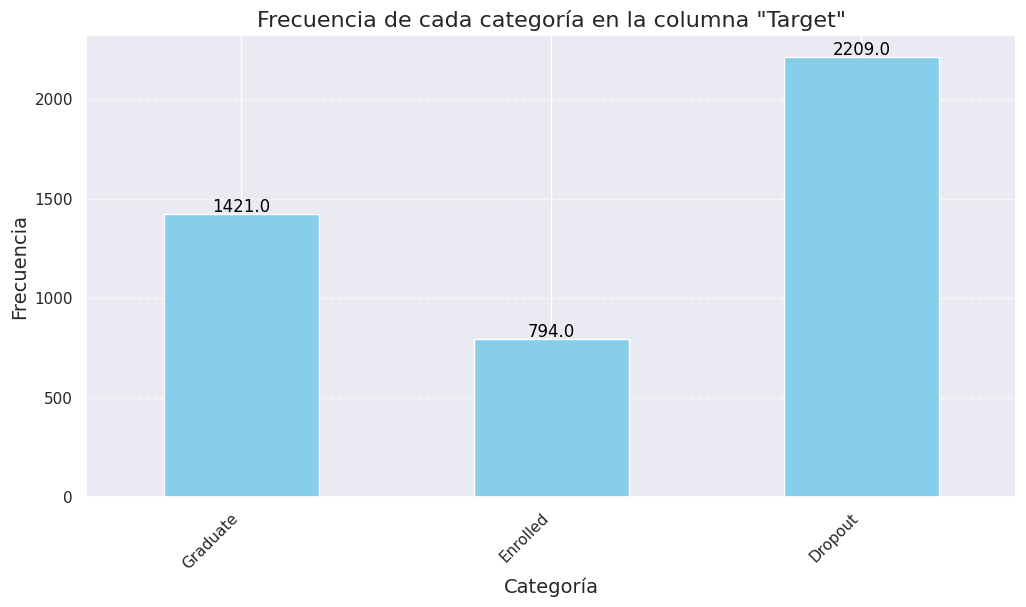

In [15]:
# Contar la frecuencia de cada categoría en las columnas 'Graduate', 'Enrolled' y 'Dropout'
frecuencias = data[['Graduate', 'Enrolled', 'Dropout']].sum()

# Crear la gráfica de barras
plt.figure(figsize=(12, 6))
ax = frecuencias.plot(kind='bar', color='skyblue')

# Añadir los valores sobre cada barra
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}',
                (p.get_x() + p.get_width() / 2, height),
                ha='center', va='center',
                xytext=(0, 5),  # Desplazamiento del texto
                textcoords='offset points',
                fontsize=12,
                color='black')

plt.title('Frecuencia de cada categoría en la columna "Target"', fontsize=16)
plt.xlabel('Categoría', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotar las etiquetas del eje x para mejor legibilidad
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Añadir líneas de cuadrícula para el eje y
plt.show()

In [16]:
# Mostrar nombres originales de columnas
print("Nombres originales de columnas:")
print(data.columns)

# Reemplazar apóstrofos en nombres de columnas
data.columns = data.columns.str.replace("'", "")

# Mostrar nombres de columnas después de la modificación
print("\nNombres de columnas después de eliminar apóstrofos:")
print(data.columns)

Nombres originales de columnas:
Index(['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance', 'Previous qualification', 'Nacionality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Displaced',
       'Educational special needs', 'Debtor', 'Tuition fees up to date',
       'Gender', 'Scholarship holder', 'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)',
       'Curricular uni

In [17]:
# Función para detectar outliers
def detectar_outliers(df, umbral=3):
    outliers_detectados = []
    for columna in df.select_dtypes(include=[np.number]).columns:
        media = df[columna].mean()
        desviacion_estandar = df[columna].std()
        limite_superior = media + umbral * desviacion_estandar
        limite_inferior = media - umbral * desviacion_estandar
        outliers = df[(df[columna] > limite_superior) | (df[columna] < limite_inferior)]
        if not outliers.empty:
            outliers_detectados.append({
                'Columna': columna,
                'Numero de Outliers': len(outliers),
                'Limite Inferior': limite_inferior,
                'Limite Superior': limite_superior
            })
    return pd.DataFrame(outliers_detectados)

In [18]:
# Función para imputar outliers con la mediana
def imputar_outliers_con_mediana(df, umbral=3):
    for columna in df.select_dtypes(include=[np.number]).columns:
        media = df[columna].mean()
        desviacion_estandar = df[columna].std()
        limite_superior = media + umbral * desviacion_estandar
        limite_inferior = media - umbral * desviacion_estandar
        mediana = df[columna].median()

        # Imputar los outliers
        df[columna] = np.where(
            (df[columna] > limite_superior) | (df[columna] < limite_inferior),
            mediana,
            df[columna]
        )
    return df



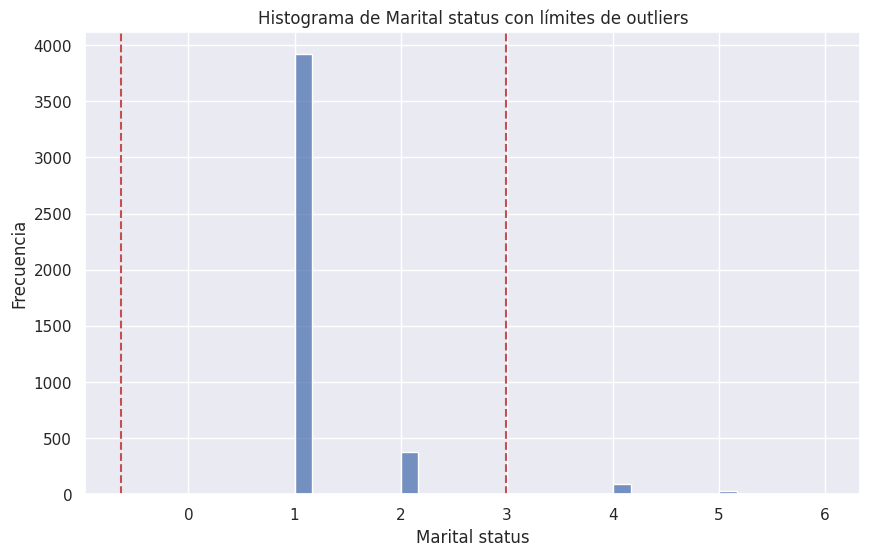

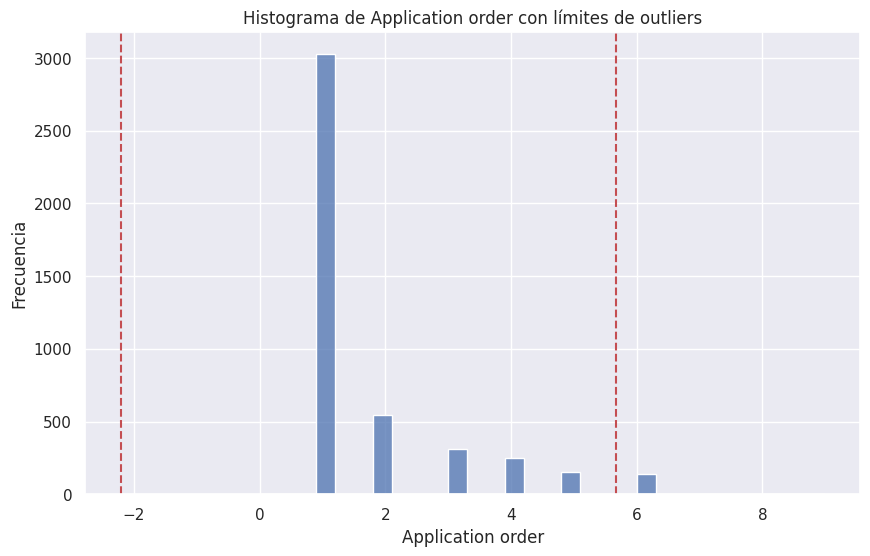

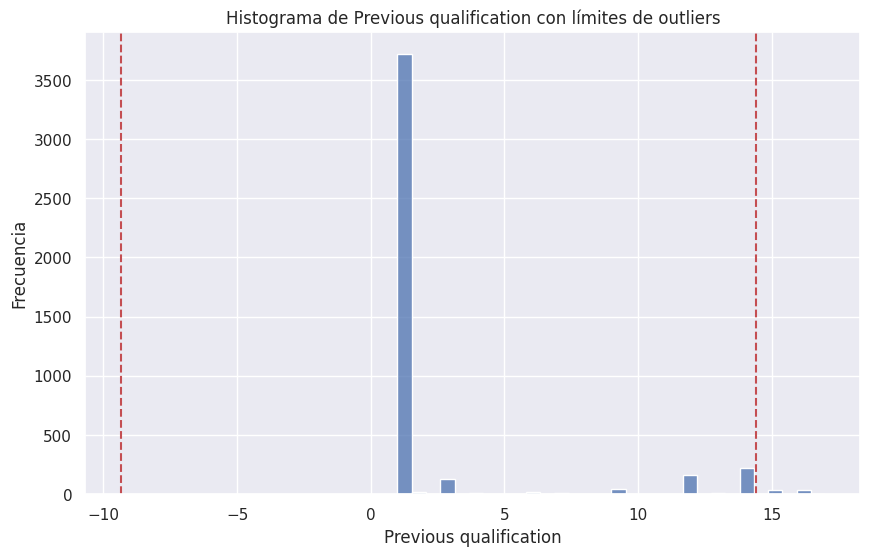

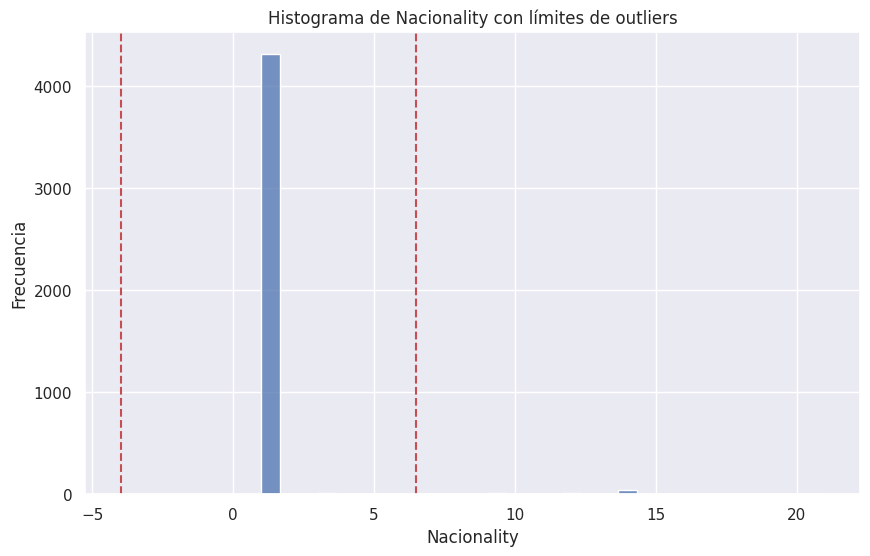

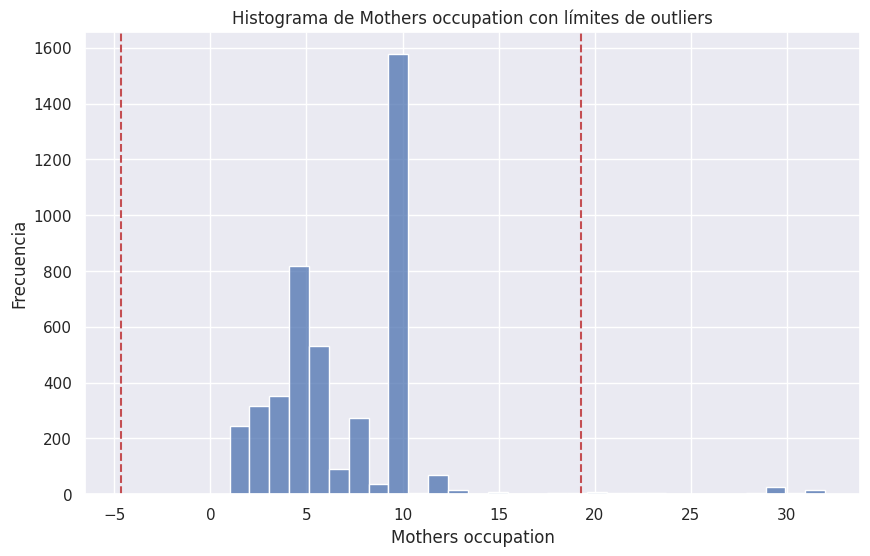

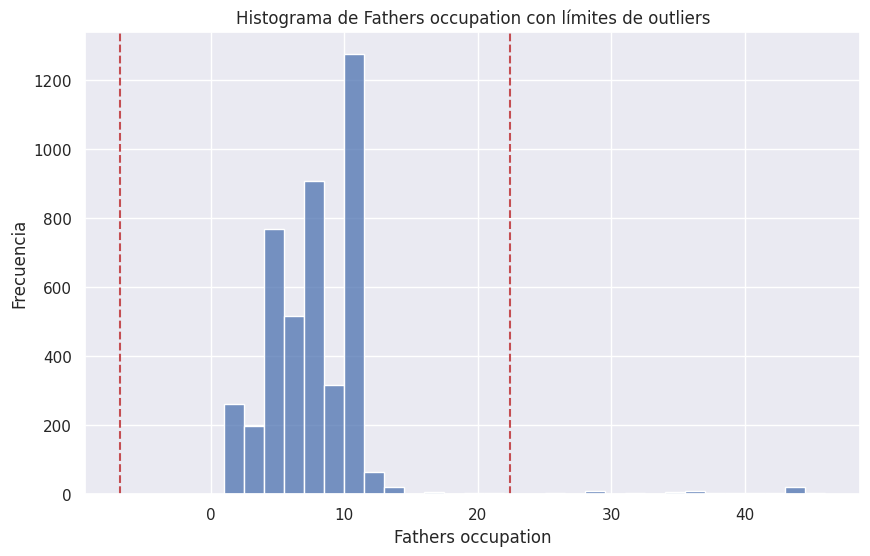

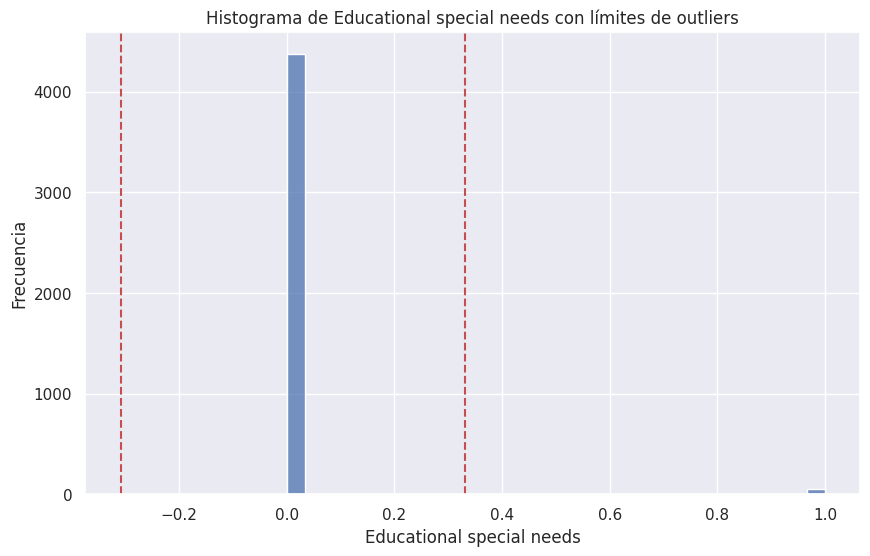

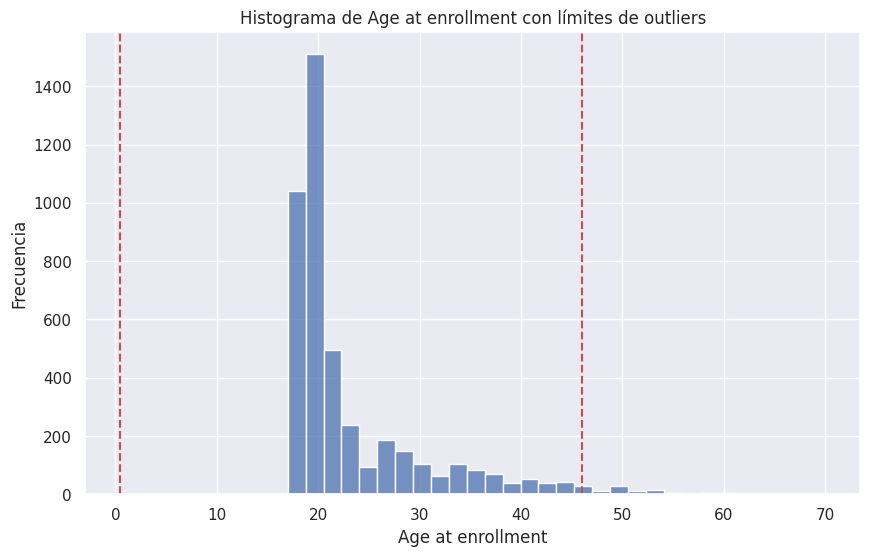

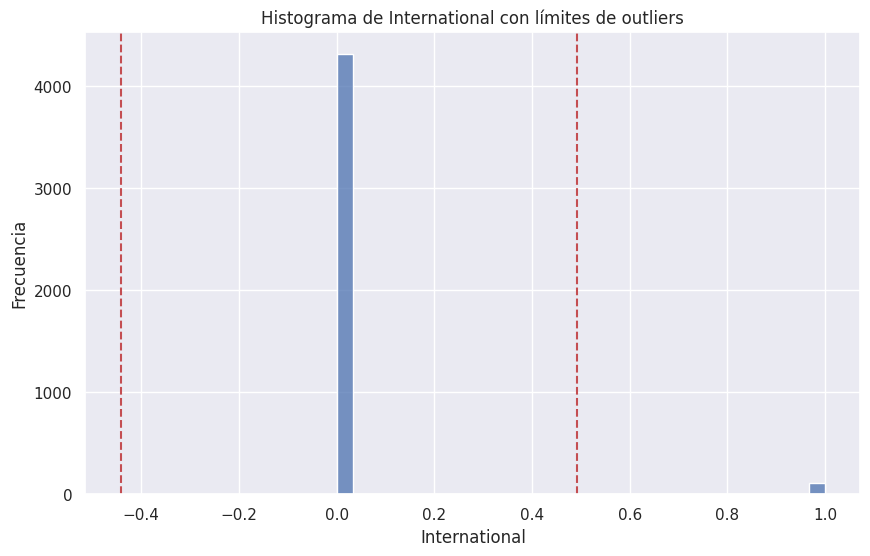

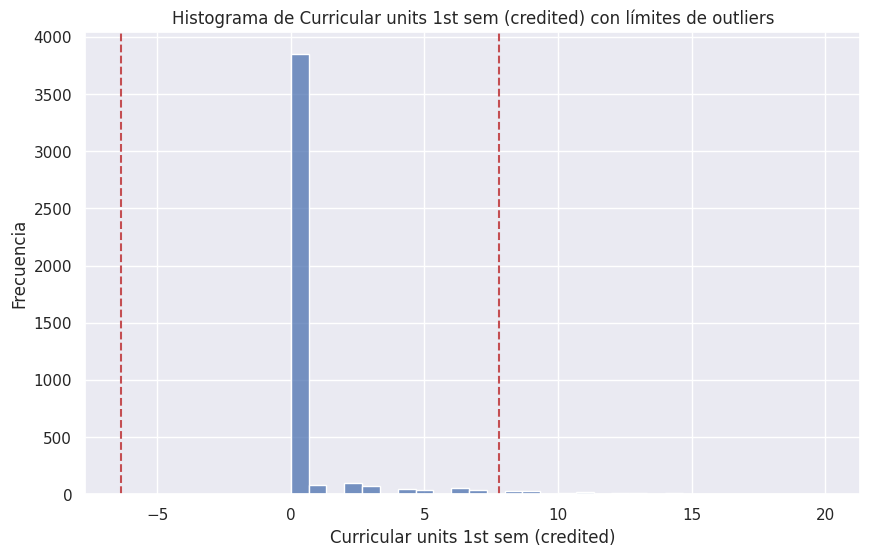

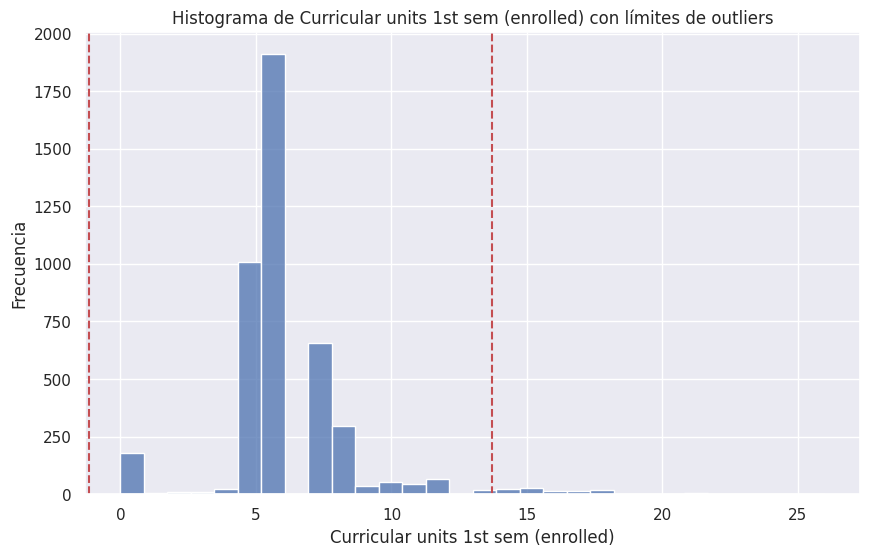

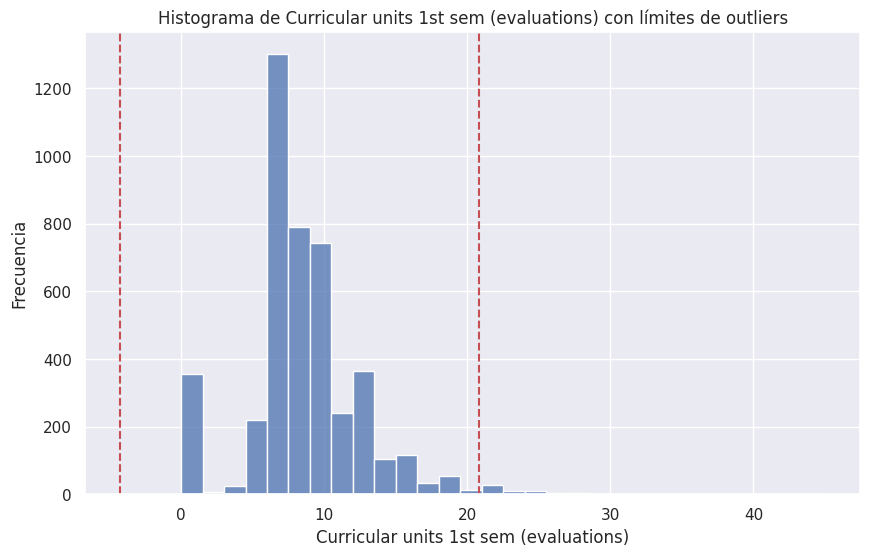

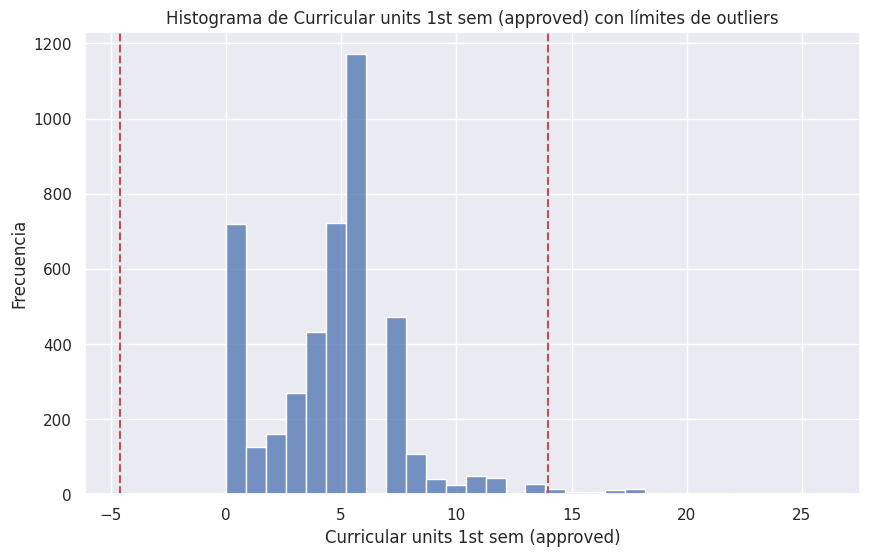

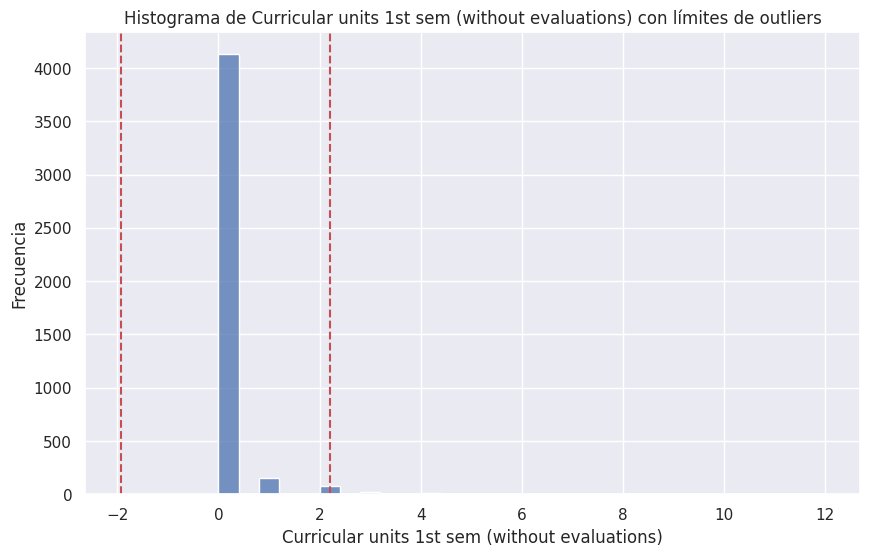

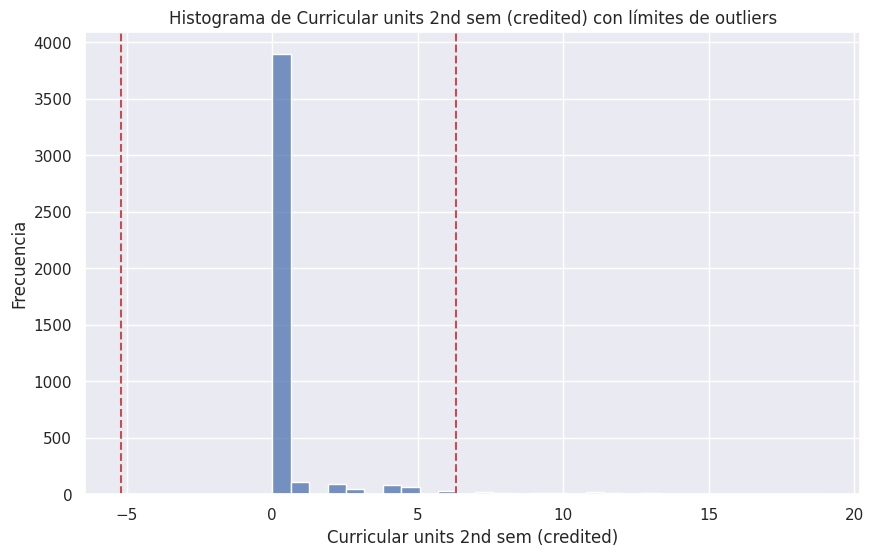

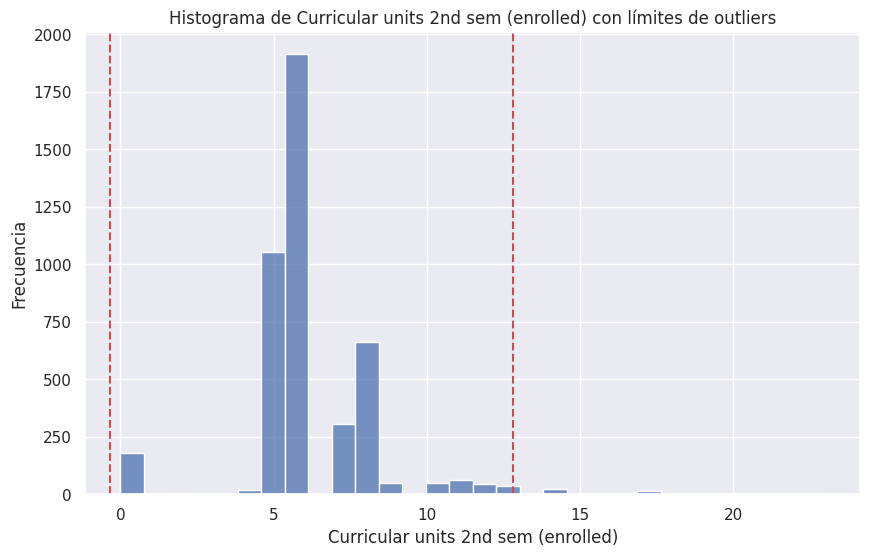

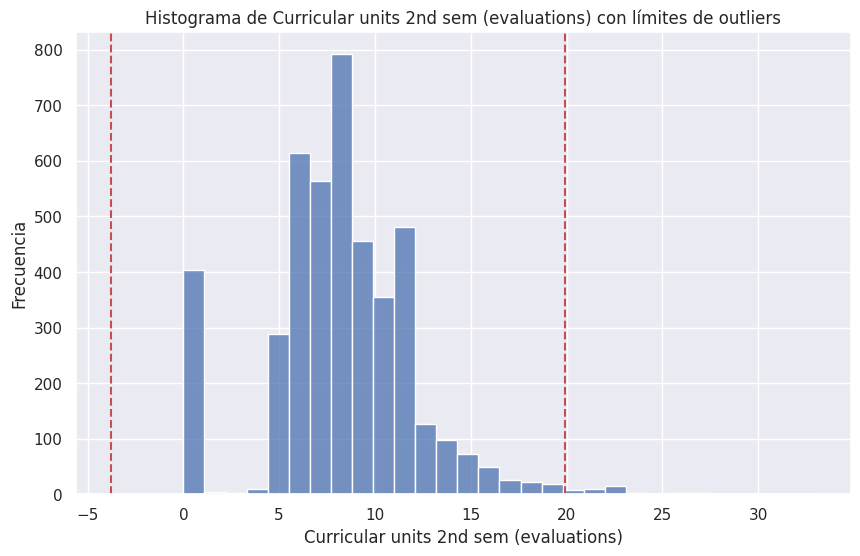

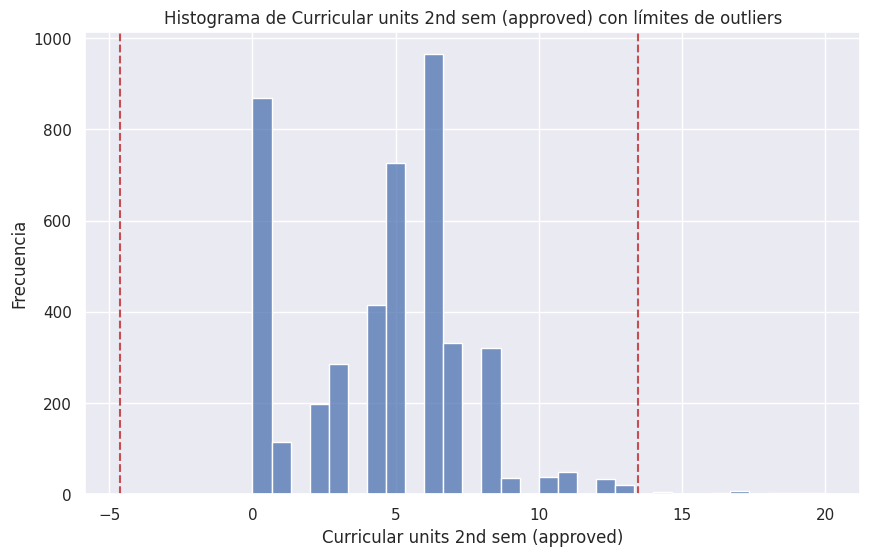

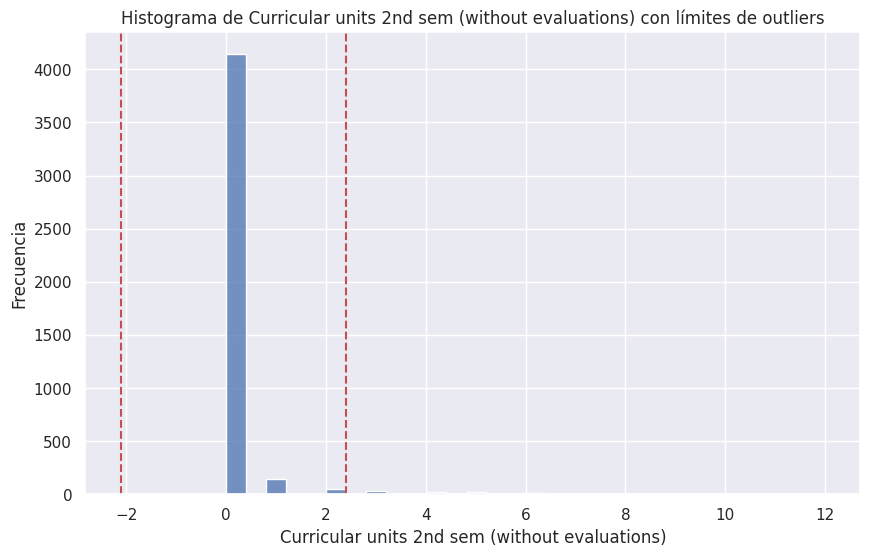

In [19]:
# Detectar outliers
outliers_df = detectar_outliers(data)

# Graficar histogramas con outliers
for columna in outliers_df['Columna']:
    plt.figure(figsize=(10, 6))
    sns.histplot(data[columna], kde=False, bins=30)
    plt.axvline(x=outliers_df[outliers_df['Columna'] == columna]['Limite Inferior'].values[0], color='r', linestyle='--')
    plt.axvline(x=outliers_df[outliers_df['Columna'] == columna]['Limite Superior'].values[0], color='r', linestyle='--')
    plt.title(f'Histograma de {columna} con límites de outliers')
    plt.xlabel(columna)
    plt.ylabel('Frecuencia')
    plt.show()

# Imputar outliers
data_imputada = imputar_outliers_con_mediana(data)

In [20]:
X = data.drop(columns=["Graduate", "Enrolled", "Dropout"])  # Características
y = data[["Graduate", "Enrolled", "Dropout"]]  # Etiquetas

# Dividir en entrenamiento (60%) y un conjunto temporal (40%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Dividir el conjunto temporal en validación (20%) y prueba (20%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [21]:
print("Dimensiones de X_train:", X_train.shape)
print("Dimensiones de y_train:", y_train.shape)

Dimensiones de X_train: (2654, 34)
Dimensiones de y_train: (2654, 3)


In [22]:
# Aplicar SMOTE solo al conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train.values)

# Crear un nuevo DataFrame para el conjunto de entrenamiento balanceado
train_set_balanced = pd.DataFrame(X_train_resampled, columns=X_train.columns)
train_set_balanced = pd.concat([train_set_balanced, pd.DataFrame(y_train_resampled, columns=["Graduate", "Enrolled", "Dropout"])], axis=1)

# Mostrar el tamaño del nuevo conjunto de entrenamiento
print(f"Tamaño del conjunto de entrenamiento balanceado: {train_set_balanced.shape[0]} filas")
print(train_set_balanced[["Graduate", "Enrolled", "Dropout"]].value_counts())

# Crear y ajustar el modelo utilizando un pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Paso 1: Escalado de características
    ('classifier', MultiOutputClassifier(RandomForestClassifier(random_state=42)))  # Paso 2: Clasificación multiclase
])

# Ajustar el pipeline con el conjunto de entrenamiento balanceado
pipeline.fit(X_train_resampled, y_train_resampled)

# Realizar predicciones en los conjuntos de validación y prueba
val_predictions = pipeline.predict(X_val)
test_predictions = pipeline.predict(X_test)

# Opcional: Imprimir las dimensiones de los conjuntos
print("Tamaño del conjunto de entrenamiento:", X_train_resampled.shape)
print("Tamaño del conjunto de validación:", X_val.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)

Tamaño del conjunto de entrenamiento balanceado: 4059 filas
Graduate  Enrolled  Dropout
0         0         1          1353
          1         0          1353
1         0         0          1353
Name: count, dtype: int64
Tamaño del conjunto de entrenamiento: (4059, 34)
Tamaño del conjunto de validación: (885, 34)
Tamaño del conjunto de prueba: (885, 34)


In [23]:
#Importancia de las caracteristicas
#Inicializar el clasificador
classifier = MultiOutputClassifier(RandomForestClassifier(random_state=42))

# Ajustar el clasificador
classifier.fit(X_train, y_train)

# Evaluar la importancia de las características usando Permutation Importance
result = permutation_importance(classifier, X_val, y_val, n_repeats=30, random_state=42)

# Crear un DataFrame para mostrar la importancia
importance_df = pd.DataFrame({
    'Feature': X.columns,  # Nombre de las características
    'Importance': result.importances_mean  # Importancia promedio
}).sort_values(by='Importance', ascending=False)

# Imprimir los resultados
print(importance_df)

                                           Feature    Importance
28             Curricular units 2nd sem (approved)  1.629755e-01
22             Curricular units 1st sem (approved)  5.804143e-02
29                Curricular units 2nd sem (grade)  4.033898e-02
14                         Tuition fees up to date  3.495292e-02
27          Curricular units 2nd sem (evaluations)  1.148776e-02
1                                 Application mode  1.047081e-02
23                Curricular units 1st sem (grade)  9.190207e-03
17                               Age at enrollment  8.512241e-03
21          Curricular units 1st sem (evaluations)  5.084746e-03
3                                           Course  3.954802e-03
9                               Mothers occupation  3.691149e-03
10                              Fathers occupation  3.502825e-03
33                                             GDP  3.389831e-03
13                                          Debtor  2.598870e-03
15                       

In [24]:
# Filtrar características por debajo del umbral de 0.0039
threshold = 0.0039
features_to_keep = importance_df[importance_df['Importance'] >= threshold]['Feature']

# Crear un nuevo DataFrame sin las características que se van a eliminar
X_filtered = X[features_to_keep]

# Mostrar las dimensiones del nuevo DataFrame
print("Tamaño del DataFrame original:", X.shape)
print("Tamaño del DataFrame filtrado:", X_filtered.shape)

Tamaño del DataFrame original: (4424, 34)
Tamaño del DataFrame filtrado: (4424, 10)


In [25]:
# Re-dividir los datos filtrados
X_train_filtered, X_temp_filtered, y_train_filtered, y_temp_filtered = train_test_split(X_filtered, y, test_size=0.4, random_state=42)

# Dividir el conjunto temporal en validación (20%) y prueba (20%)
X_val_filtered, X_test_filtered, y_val_filtered, y_test_filtered = train_test_split(X_temp_filtered, y_temp_filtered, test_size=0.5, random_state=42)

# Aplicar SMOTE solo al conjunto de entrenamiento filtrado
smote = SMOTE(random_state=42)
X_train_resampled_filtered, y_train_resampled_filtered = smote.fit_resample(X_train_filtered, y_train_filtered.values)

# Crear un nuevo DataFrame para el conjunto de entrenamiento balanceado
train_set_balanced_filtered = pd.DataFrame(X_train_resampled_filtered, columns=X_train_filtered.columns)
train_set_balanced_filtered = pd.concat([train_set_balanced_filtered, pd.DataFrame(y_train_resampled_filtered, columns=["Graduate", "Enrolled", "Dropout"])], axis=1)

# Mostrar el tamaño del nuevo conjunto de entrenamiento balanceado
print(f"Tamaño del conjunto de entrenamiento balanceado (filtrado): {train_set_balanced_filtered.shape[0]} filas")

# Crear y ajustar el nuevo modelo utilizando un pipeline
pipeline_filtered = Pipeline([
    ('scaler', StandardScaler()),  # Paso 1: Escalado de características
    ('classifier', MultiOutputClassifier(RandomForestClassifier(random_state=42)))  # Paso 2: Clasificación multiclase
])

# Ajustar el pipeline con el conjunto de entrenamiento balanceado filtrado
pipeline_filtered.fit(X_train_resampled_filtered, y_train_resampled_filtered)

# Realizar predicciones en los conjuntos de validación y prueba filtrados
val_predictions_filtered = pipeline_filtered.predict(X_val_filtered)
test_predictions_filtered = pipeline_filtered.predict(X_test_filtered)

# Opcional: Imprimir las dimensiones de los conjuntos filtrados
print("Tamaño del conjunto de entrenamiento (filtrado):", X_train_resampled_filtered.shape)
print("Tamaño del conjunto de validación (filtrado):", X_val_filtered.shape)
print("Tamaño del conjunto de prueba (filtrado):", X_test_filtered.shape)

Tamaño del conjunto de entrenamiento balanceado (filtrado): 4059 filas
Tamaño del conjunto de entrenamiento (filtrado): (4059, 10)
Tamaño del conjunto de validación (filtrado): (885, 10)
Tamaño del conjunto de prueba (filtrado): (885, 10)


Evaluación del modelo de Regresión Logística:
              precision    recall  f1-score   support

           0       0.84      0.68      0.75       291
           1       0.44      0.36      0.40       160
           2       0.86      0.75      0.80       434

   micro avg       0.78      0.66      0.71       885
   macro avg       0.71      0.60      0.65       885
weighted avg       0.78      0.66      0.71       885
 samples avg       0.65      0.66      0.65       885

F1 Score (Macro) con Validación Cruzada: 0.509990212979637


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Mejores Parámetros para SVM con Kernel RBF: {'estimator__C': 10, 'estimator__gamma': 0.1, 'estimator__kernel': 'rbf'}
Reporte de Clasificación para SVM con Kernel RBF:
              precision    recall  f1-score   support

           0       0.72      0.60      0.66       291
           1       0.40      0.28      0.32       160
           2       0.81      0.74      0.78       434

   micro avg       0.72      0.61      0.66       885
   macro avg       0.64      0.54      0.59       885
weighted avg       0.71      0.61      0.66       885
 samples avg       0.60      0.61      0.60       885

Mejores Parámetros para SVM con Kernel Lineal: {'estimator__C': 10, 'estimator__kernel': 'linear'}
Reporte de Clasificación para SVM con Kernel Lineal:
              precision    recall  f1-score   support

           0       0.82      0.66      0.73       291
           1       0.43      0.29      0.35       160
           2       0.87      0.75      0.80       434

   micro avg       0.78    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Mejores Parámetros para SVM con Kernel Polinómico: {'estimator__C': 10, 'estimator__coef0': 1, 'estimator__degree': 4, 'estimator__kernel': 'poly'}
Reporte de Clasificación para SVM con Kernel Polinómico:
              precision    recall  f1-score   support

           0       0.85      0.62      0.72       291
           1       0.43      0.54      0.48       160
           2       0.84      0.77      0.81       434

   micro avg       0.74      0.68      0.71       885
   macro avg       0.71      0.65      0.67       885
weighted avg       0.77      0.68      0.72       885
 samples avg       0.67      0.68      0.68       885

                Modelo  F1 Score (Macro)
0  Regresión Logística          0.509990
1      SVM (Gaussiano)          0.691893
2         SVM (Lineal)          0.500388
3     SVM (Polinómico)          0.550310


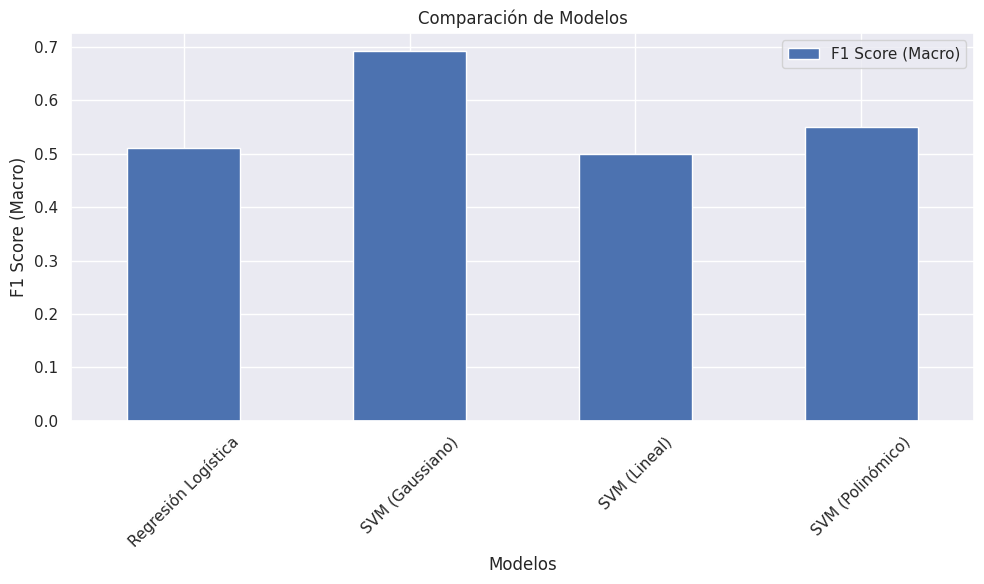

In [46]:
# ------------------------------------------
# Ajustar modelo de Regresión Logística con Validación Cruzada
# ------------------------------------------

# Crear un pipeline para la regresión logística
pipeline_logistic = Pipeline([
    ('scaler', StandardScaler()),  # Paso 1: Escalado de características
    ('classifier', MultiOutputClassifier(LogisticRegression(random_state=42)))  # Paso 2: Clasificación multiclase
])

# Realizar validación cruzada
cv_scores_logistic = cross_val_score(pipeline_logistic, X_train_resampled_filtered, y_train_resampled_filtered, cv=5, scoring='f1_macro')

# Ajustar el pipeline con el conjunto de entrenamiento balanceado filtrado
pipeline_logistic.fit(X_train_resampled_filtered, y_train_resampled_filtered)

# Realizar predicciones en el conjunto de prueba
logistic_predictions = pipeline_logistic.predict(X_test_filtered)

# Evaluar el modelo de regresión logística
print("Evaluación del modelo de Regresión Logística:")
print(classification_report(y_test_filtered, logistic_predictions))
print("F1 Score (Macro) con Validación Cruzada:", cv_scores_logistic.mean())

# ------------------------------------------
# Modelos SVM con diferentes kernels con Validación Cruzada
# ------------------------------------------

def evaluate_svm_model(param_grid, X_train, y_train, X_test):
    grid_search = GridSearchCV(MultiOutputClassifier(SVC()), param_grid, cv=3, scoring='f1_macro', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    y_pred = grid_search.predict(X_test)

    # Realizar validación cruzada en el mejor modelo encontrado
    cv_scores_svm = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5, scoring='f1_macro')

    return grid_search.best_params_, {
        'report': classification_report(y_test_filtered, y_pred, output_dict=True),
        'y_pred': y_pred,
        'cv_score': cv_scores_svm.mean()
    }

# SVM con Kernel Gaussiano (RBF)
param_grid_rbf = {
    'estimator__C': [0.1, 1, 10, 100],
    'estimator__gamma': [0.001, 0.01, 0.1, 1],
    'estimator__kernel': ['rbf']
}
best_params_rbf, rbf_report = evaluate_svm_model(param_grid_rbf, X_train_resampled_filtered, y_train_resampled_filtered, X_test_filtered)
print("Mejores Parámetros para SVM con Kernel RBF:", best_params_rbf)
print("Reporte de Clasificación para SVM con Kernel RBF:")
print(classification_report(y_test_filtered, rbf_report['y_pred']))

# SVM con Kernel Lineal
param_grid_linear = {
    'estimator__C': [0.1, 1, 10, 100],
    'estimator__kernel': ['linear']
}
best_params_linear, linear_report = evaluate_svm_model(param_grid_linear, X_train_resampled_filtered, y_train_resampled_filtered, X_test_filtered)
print("Mejores Parámetros para SVM con Kernel Lineal:", best_params_linear)
print("Reporte de Clasificación para SVM con Kernel Lineal:")
print(classification_report(y_test_filtered, linear_report['y_pred']))

# SVM con Kernel Polinómico
param_grid_poly = {
    'estimator__C': [0.1, 1, 10],
    'estimator__degree': [2, 3, 4],
    'estimator__coef0': [0, 1],
    'estimator__kernel': ['poly']
}
best_params_poly, poly_report = evaluate_svm_model(param_grid_poly, X_train_resampled_filtered, y_train_resampled_filtered, X_test_filtered)
print("Mejores Parámetros para SVM con Kernel Polinómico:", best_params_poly)
print("Reporte de Clasificación para SVM con Kernel Polinómico:")
print(classification_report(y_test_filtered, poly_report['y_pred']))

# ------------------------------------------
# Comparación de Resultados
# ------------------------------------------

# Crear un DataFrame para la comparación
comparison_df = pd.DataFrame({
    'Modelo': ['Regresión Logística', 'SVM (Gaussiano)', 'SVM (Lineal)', 'SVM (Polinómico)'],
    'F1 Score (Macro)': [
        cv_scores_logistic.mean(),
        rbf_report['cv_score'],
        linear_report['cv_score'],
        poly_report['cv_score']
    ]
})

print(comparison_df)

# Visualización de la comparación
comparison_df.set_index('Modelo').plot(kind='bar', figsize=(10, 6))
plt.title('Comparación de Modelos')
plt.ylabel('F1 Score (Macro)')
plt.xlabel('Modelos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

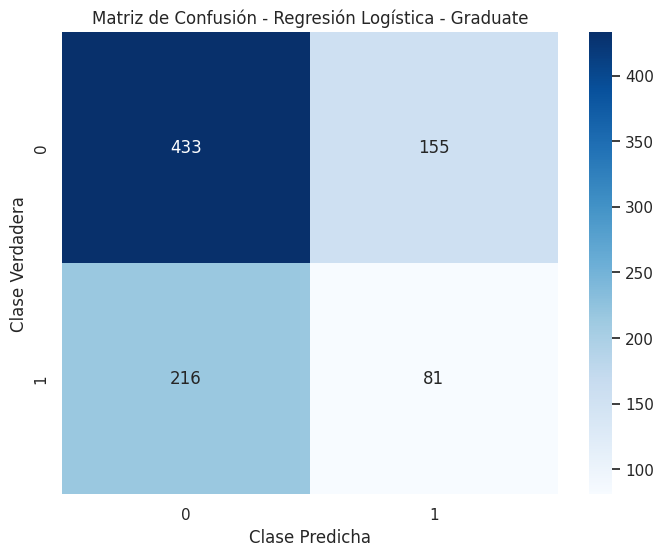

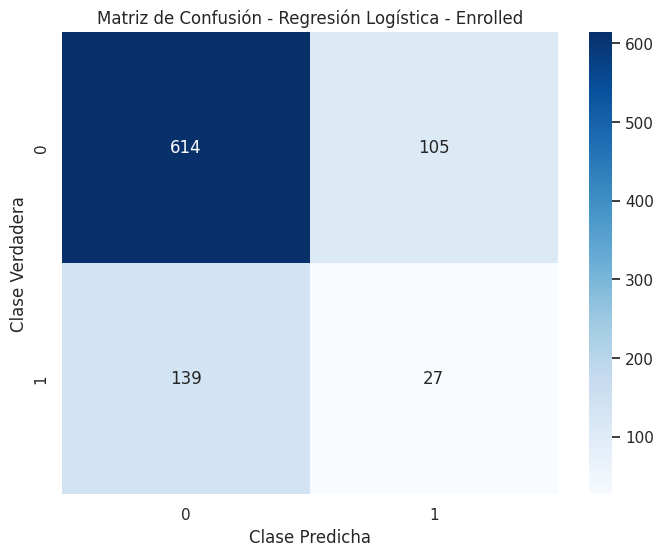

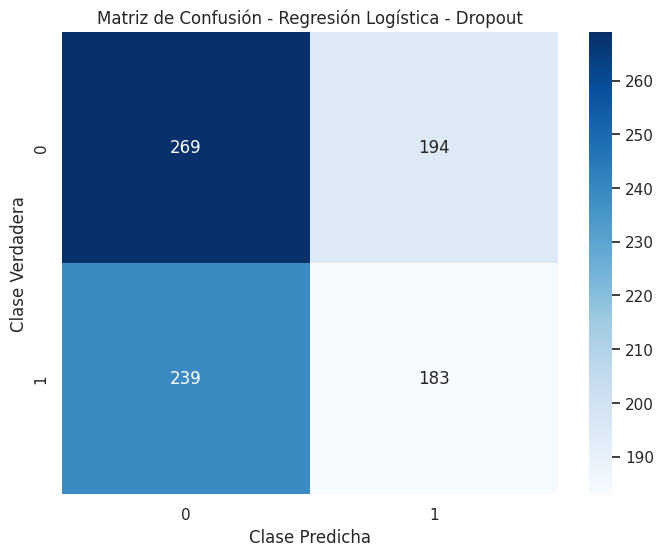

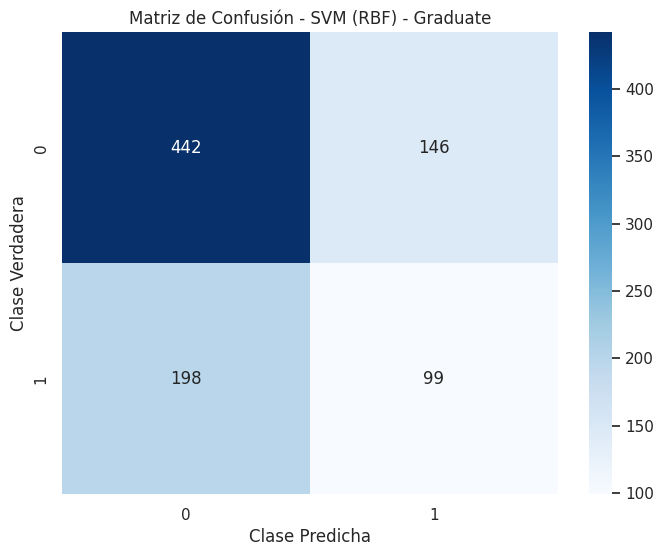

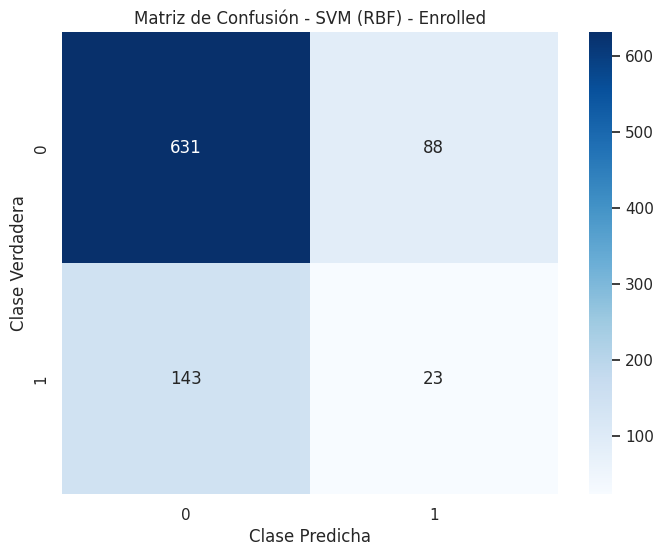

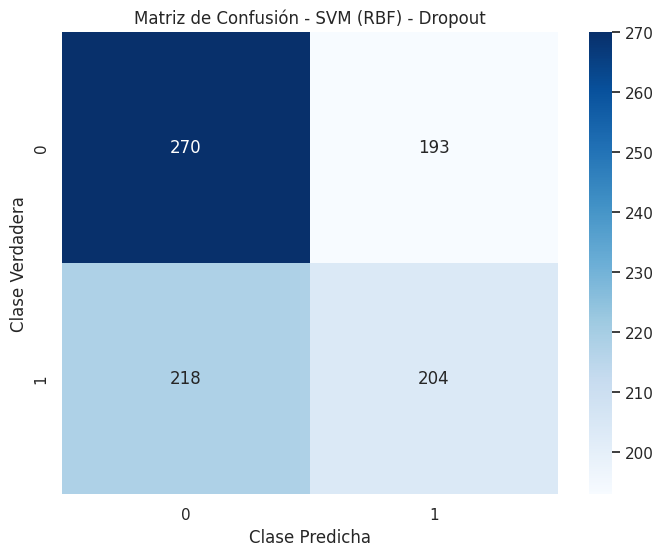

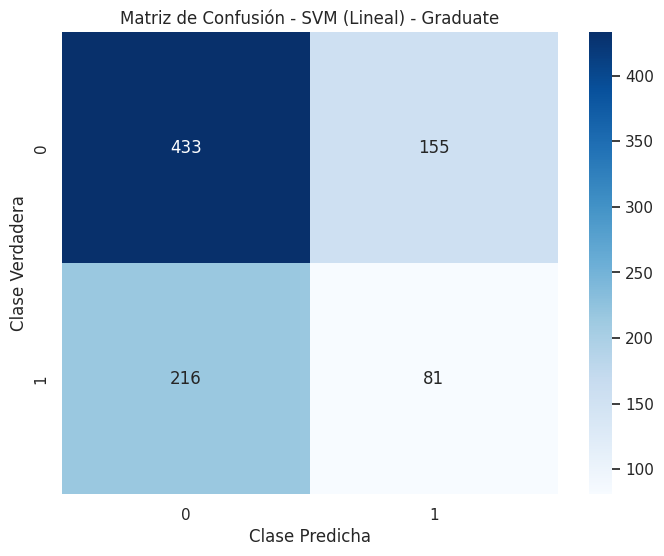

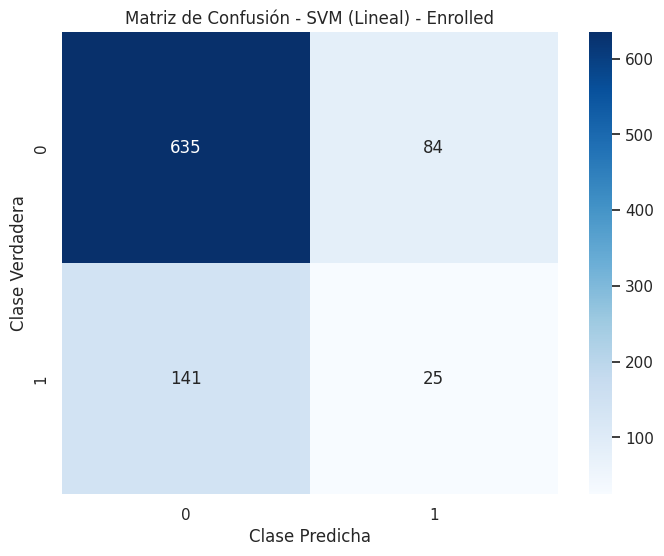

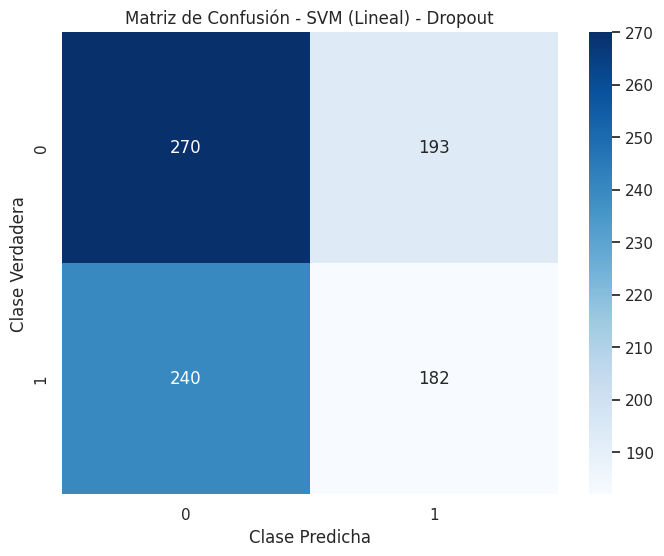

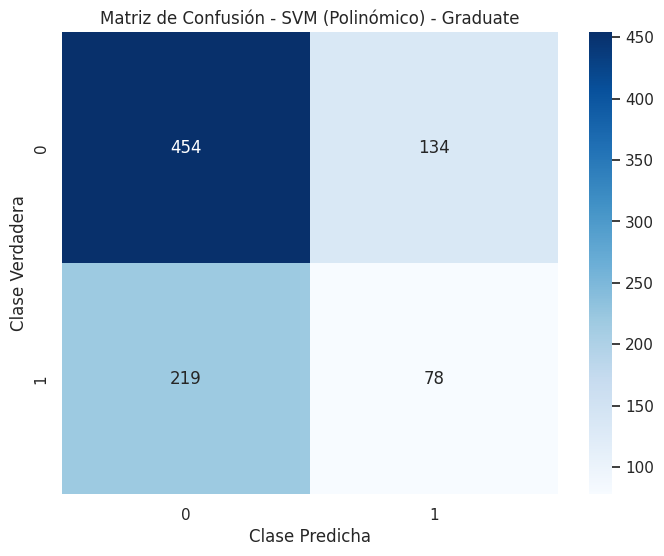

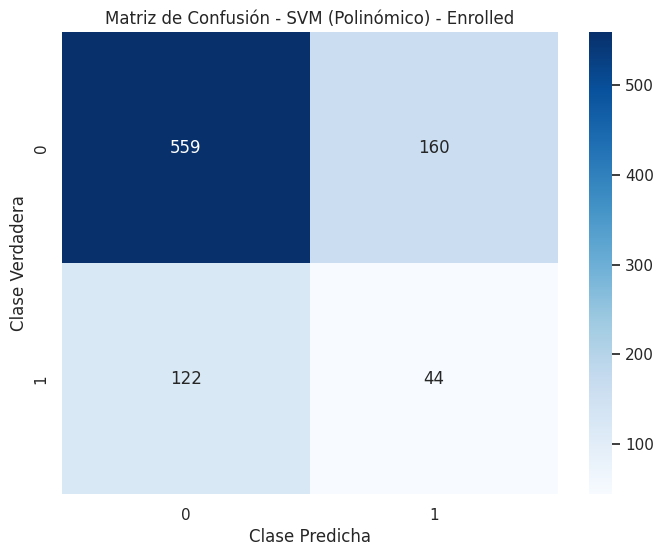

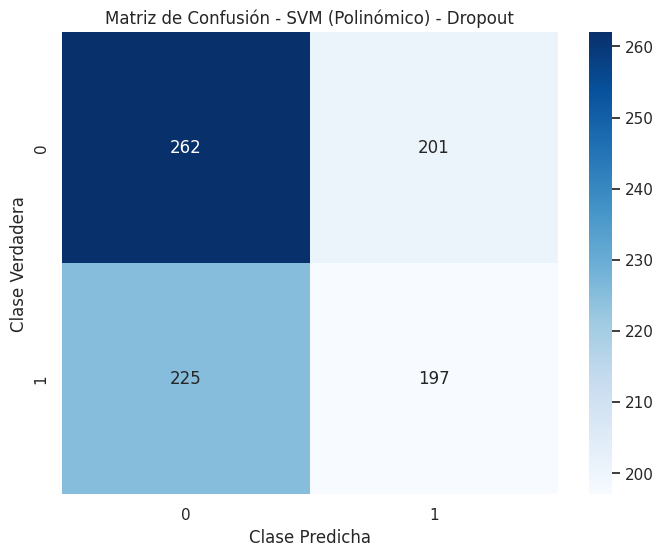

In [49]:
# Función para imprimir matrices de confusión para clasificación multietiqueta
def plot_confusion_matrices(y_true, y_pred, title='Matriz de Confusión'):
    # Convertir a DataFrame para facilitar el manejo
    y_true_df = pd.DataFrame(y_true, columns=["Graduate", "Enrolled", "Dropout"])
    y_pred_df = pd.DataFrame(y_pred, columns=["Graduate", "Enrolled", "Dropout"])

    for column in y_true_df.columns:
        cm = confusion_matrix(y_true_df[column], y_pred_df[column])
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
        plt.ylabel('Clase Verdadera')
        plt.xlabel('Clase Predicha')
        plt.title(f'{title} - {column}')
        plt.show()

# Matriz de confusión para Regresión Logística
plot_confusion_matrices(y_val_filtered.values, logistic_predictions, title='Matriz de Confusión - Regresión Logística')

# Matriz de confusión para SVM con Kernel RBF
plot_confusion_matrices(y_val_filtered.values, rbf_report['y_pred'], title='Matriz de Confusión - SVM (RBF)')

# Matriz de confusión para SVM con Kernel Lineal
plot_confusion_matrices(y_val_filtered.values, linear_report['y_pred'], title='Matriz de Confusión - SVM (Lineal)')

# Matriz de confusión para SVM con Kernel Polinómico
plot_confusion_matrices(y_val_filtered.values, poly_report['y_pred'], title='Matriz de Confusión - SVM (Polinómico)')

In [51]:
# Almacenar el modelo entrenado en un archivo .joblib
filename_joblib = 'final_model.joblib'
joblib.dump(pipeline_filtered, filename_joblib)

# Almacenar el modelo entrenado en un archivo .sav
filename_sav = 'final_model.sav'
with open(filename_sav, 'wb') as file:
    pickle.dump(pipeline_filtered, file)

# Cargar el modelo desde el archivo .sav
with open(filename_sav, 'rb') as file:
    loaded_model = pickle.load(file)

# Obtener el clasificador del pipeline
multi_output_classifier = loaded_model.named_steps['classifier']

print('Mejores hiperparámetros:', random_search.best_params_)

# Iterar sobre los clasificadores y mostrar información
for i, classifier in enumerate(multi_output_classifier.estimators_):
    print(f'Clasificador {i + 1}:')

    if hasattr(classifier, 'coef_'):
        print('Coeficientes del clasificador:', classifier.coef_)
    else:
        print('El clasificador no tiene coeficientes (no es un clasificador lineal).')

    if hasattr(classifier, 'intercept_'):
        print('Intercepto del clasificador:', classifier.intercept_)
    else:
        print('El clasificador no tiene intercepto (no es un clasificador lineal).')

Mejores hiperparámetros: {'classifier__estimator__max_iter': 1000, 'classifier__estimator__C': 1000}
Clasificador 1:
El clasificador no tiene coeficientes (no es un clasificador lineal).
El clasificador no tiene intercepto (no es un clasificador lineal).
Clasificador 2:
El clasificador no tiene coeficientes (no es un clasificador lineal).
El clasificador no tiene intercepto (no es un clasificador lineal).
Clasificador 3:
El clasificador no tiene coeficientes (no es un clasificador lineal).
El clasificador no tiene intercepto (no es un clasificador lineal).
